In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1. Data Cleaning (NaNs)

First, we import the data set and take a look at it

In [6]:
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
nan_df = house_df.copy()
nan_df.shape

(9974, 20)

In [7]:
#get columns with NaN data
nan_df.isna().sum()

district                                 0
is_incumbent                           112
name                                     0
party                                    0
percent                                 15
state                                    0
votes                                   67
won                                      0
year                                     0
first_time_elected                    4445
count_victories                          0
unemployement_rate                     979
is_presidential_year                   102
president_can_be_re_elected            102
president_party                        102
president_overall_avg_job_approval    1060
last_D_house_seats                     102
last_R_house_seats                     102
last_house_majority                    102
fundraising                           7172
dtype: int64

In [8]:
#get rid of NaNs
def clean_nan(data):
    
    #iterate over all data and replace NaN
    for i in range(data.shape[0]):
        
        #selections used below
        dist_state = data[(data.district == data.district.iloc[i]) & 
                          (data.state == data.state.iloc[i])]
        dist_state_year = data[(data.district == data.district.iloc[i]) & 
                               (data.state == data.state.iloc[i]) & 
                               (data.year == data.year.iloc[i])]
        
        #votes NaN will be replaced with mean of votes from state and district
        if np.isnan(data.votes.iloc[i]):
            data.votes.iloc[i] = dist_state.votes.mean()
            
        #is_incumbent NaN will be replaced: if sum of is_incumbent for state/district/year > 0 then assign 0. Else 1
        if np.isnan(data.is_incumbent.iloc[i]):
            if dist_state_year.is_incumbent.sum() > 0:
                data.is_incumbent.iloc[i] = 0
            else:
                data.is_incumbent.iloc[i] = 1
                
        #Percent: calculate based on percent per state/district/year and subtract from 100
        if np.isnan(data.percent.iloc[i]):
            data.percent.iloc[i] = 100 - dist_state_year.percent.sum()
            
        #first_time_elected: take from year if won=1 else 0
        if np.isnan(data.first_time_elected.iloc[i]):
            if data.won.iloc[i] == 1:
                data.first_time_elected.iloc[i] = data.year.iloc[i]
            else:
                data.first_time_elected.iloc[i] = 0
                
        #unemployement_rate: set to 0
        if np.isnan(data.unemployement_rate.iloc[i]):
            data.unemployement_rate.iloc[i] = 0
            
        #is_presidential_year: set to 0
        if np.isnan(data.is_presidential_year.iloc[i]):
            data.is_presidential_year.iloc[i] = 0            

        #president_can_be_re_elected: set to 1
        if np.isnan(data.president_can_be_re_elected.iloc[i]):
            data.president_can_be_re_elected.iloc[i] = 1

        #president_party: set to 0
        if pd.isnull(data.president_party.iloc[i]):
            data.president_party.iloc[i] = 0
            
        #president_overall_avg_job_approval: mean for state/district
        if np.isnan(data.president_overall_avg_job_approval.iloc[i]):
                data.president_overall_avg_job_approval.iloc[i] = dist_state.president_overall_avg_job_approval.mean()
            
        #last_D_house_seats: mean for state/district
        if np.isnan(data.last_D_house_seats.iloc[i]):
            data.last_D_house_seats.iloc[i] = dist_state.last_D_house_seats.mean()  
            
        #last_R_house_seats: mean for state/district
        if np.isnan(data.last_R_house_seats.iloc[i]):
            data.last_R_house_seats.iloc[i] = dist_state.last_R_house_seats.mean() 

        #last_house_majority: most occurence for state/district
        if pd.isnull(data.last_house_majority.iloc[i]):
            data.last_house_majority.iloc[i] = max(dist_state.last_house_majority.iteritems())

        #fundraising: mean for state/district
        if np.isnan(data.fundraising.iloc[i]):
            data.fundraising.iloc[i] = dist_state.fundraising.mean() 
        
            
    data['votes'] = pd.to_numeric(data['votes']).round(0).astype(int)

    return data

In [9]:
#clean orignal dataset nan_df
clean_df = clean_nan(nan_df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
#check if there are remaining NaN
clean_df.isna().sum()

district                                0
is_incumbent                            0
name                                    0
party                                   0
percent                                 0
state                                   0
votes                                   0
won                                     0
year                                    0
first_time_elected                      0
count_victories                         0
unemployement_rate                      0
is_presidential_year                    0
president_can_be_re_elected             0
president_party                         0
president_overall_avg_job_approval      0
last_D_house_seats                      0
last_R_house_seats                      0
last_house_majority                     0
fundraising                           172
dtype: int64

In [11]:
#delete lines with NaN
nan_df = clean_df.dropna()

In [18]:
#no NaNs should be there anymore
nan_df.isna().sum()
nan_df.to_csv('data/house_mean_imputation.csv', index=False)

# 2. PCA

In [13]:
#category columns cannot be used for PCA analyzes so we delete them
del_columns = ['party','district','president_party','last_house_majority', 'name', 'state']

#function return the pca object and the scaled dataframe used for PCA
def pca_with_scale(data,del_columns=del_columns):
    #returns pca object and dataframe
    #data: input dataframe
    #del_columns: array with columns to be deleted e.g. columns with strings cannot be used for pca analyzes
    
    #drop all columns with category data  
    data = data.drop(columns = del_columns)
    #just to make sure data has no NaN values
    scale_df = StandardScaler().fit_transform(data)
    scale_df = pd.DataFrame(data=scale_df,    # values
#              index=data[1:,0],    # 1st column as index
              columns=data.columns)  # 1st row as the column names
    scale_df = scale_df.dropna()
    pca = PCA(n_components = scale_df.shape[1]).fit(scale_df)
    return pca, scale_df

In [14]:
#get PCA object
pca, scale_df = pca_with_scale(nan_df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
print("Number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<=0.9)[0])+1)

Number of components that explain at least 90% of the variance= 8


Text(0.5,1,'Cumulative variance explained')

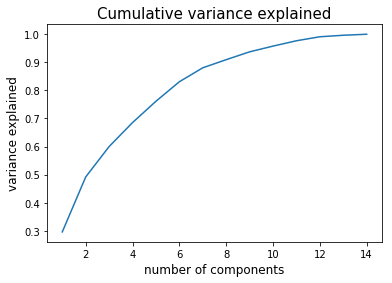

In [16]:
#Plot the variance, cumulated per component
plt.plot(np.linspace(1, scale_df.shape[1], scale_df.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components', fontsize=12)
plt.ylabel('variance explained', fontsize=12)
plt.title('Cumulative variance explained',fontsize=15)

Text(0.5,1,'Variance explained by each component')

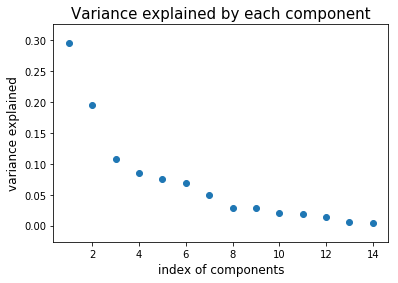

In [17]:
#Plot the 
plt.scatter(range(1, scale_df.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('index of components', fontsize=12)
plt.ylabel('variance explained', fontsize=12)
plt.title('Variance explained by each component',fontsize=15)